<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/L27-GraphNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Machine Learning



In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

In [ ]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.8/887.8 kB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Facebook Page-Page dataset

This dataset was introduced by [Rozemberczki et al. in 2019](https://arxiv.org/abs/1909.13021). It was created using the Facebook Graph API in November 2017. In this dataset, each of the 22,470 nodes represents an official Facebook page. Pages are connected when there are mutual likes between them. Node features (128-dim vectors) are created from textual descriptions written by the owners of these pages. Our goal is to classify each node into one of four categories:

- politicians
- companies
- television shows
- governmental organizations.

The Facebook Page-Page dataset is similar to the previous one: it’s a social network with a node classification task. However, there are three major differences with Cora:

The number of nodes is much higher (2,708 versus 22,470)
The dimensionality of the node features decreased dramatically (from 1,433 to 128)
The goal is to classify each node into four categories instead of seven (which is easier since there are fewer options)
The following figure is a visualization of the dataset using Gephi. First, nodes with few connections have been filtered out to improve performance. The size of the remaining nodes depends on their number of connections, and their color indicates the category they belong to. Finally, two layouts have been applied: Fruchterman-Reingold and ForceAtlas2.

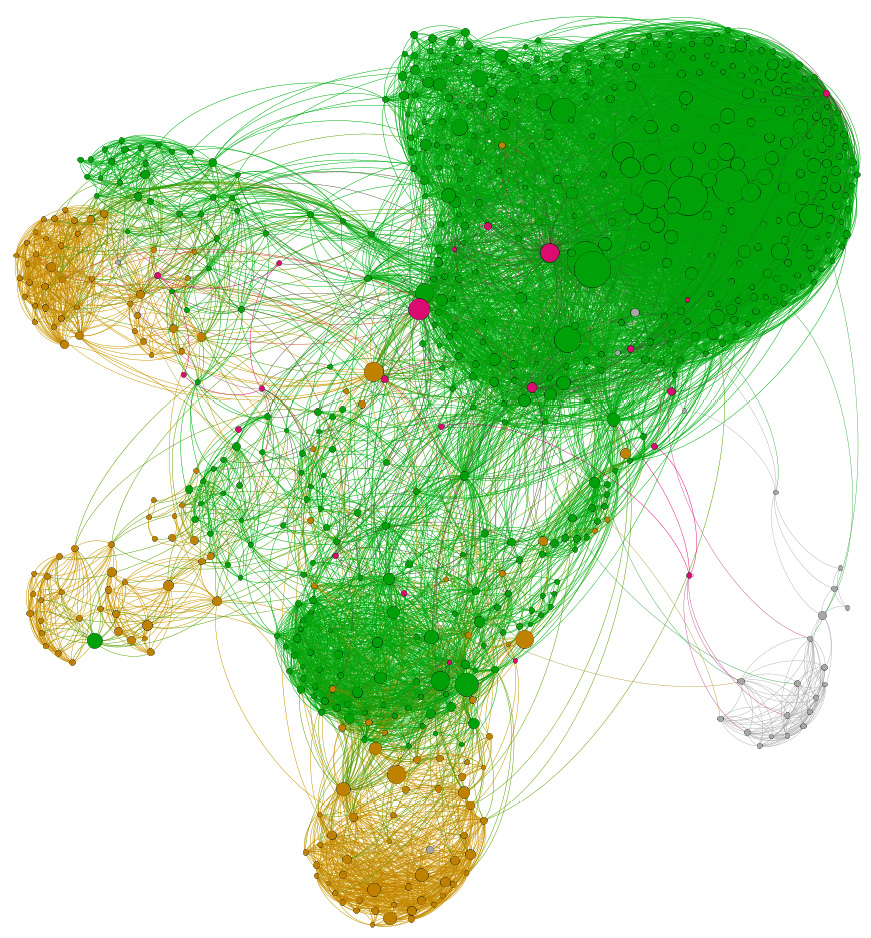

### Load dataset

In [ ]:
from torch_geometric.datasets import FacebookPagePage

# Import dataset from PyTorch Geometric
dataset = FacebookPagePage(root=".")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

# Create masks
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

Processing...
Done!


Dataset: FacebookPagePage()
-----------------------
Number of graphs: 1
Number of nodes: 22470
Number of features: 128
Number of classes: 4

Graph:
------
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: True


## Visualizing the graph

Se procede a realizar tanto la gráfica random como la gráfica por spring layout

In [ ]:
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

In [ ]:
G = nx.from_pandas_edgelist(edge_index_list, "start_node", "end_node")

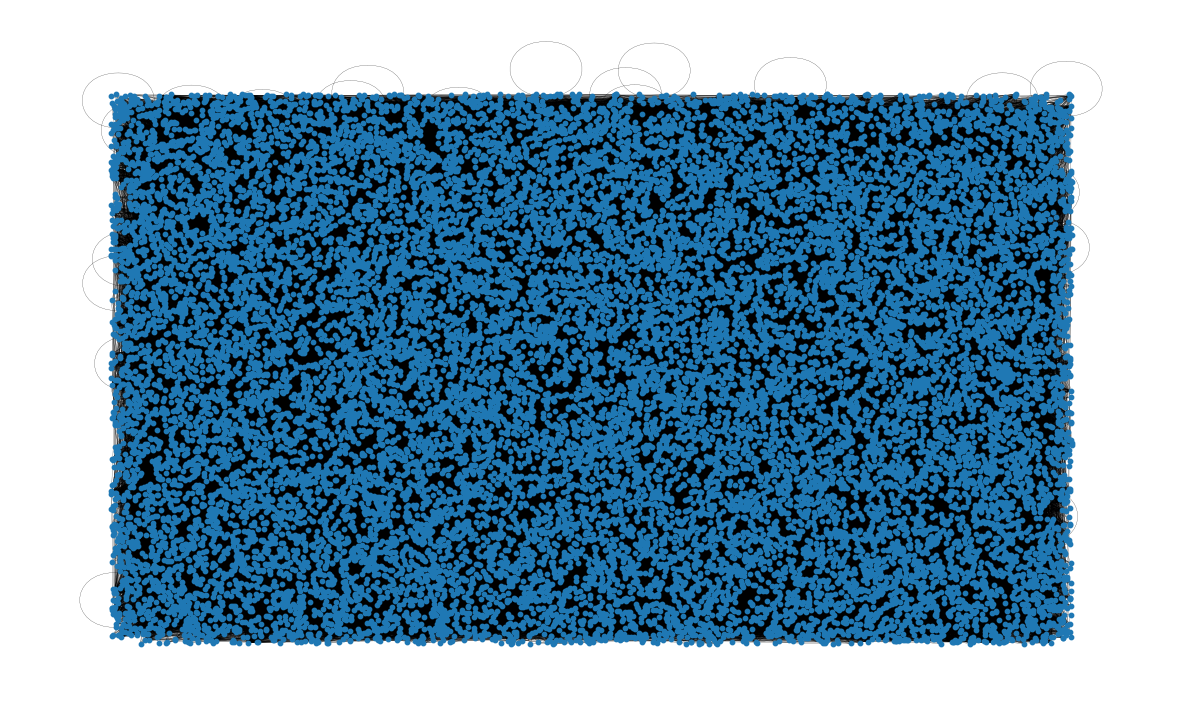

In [ ]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

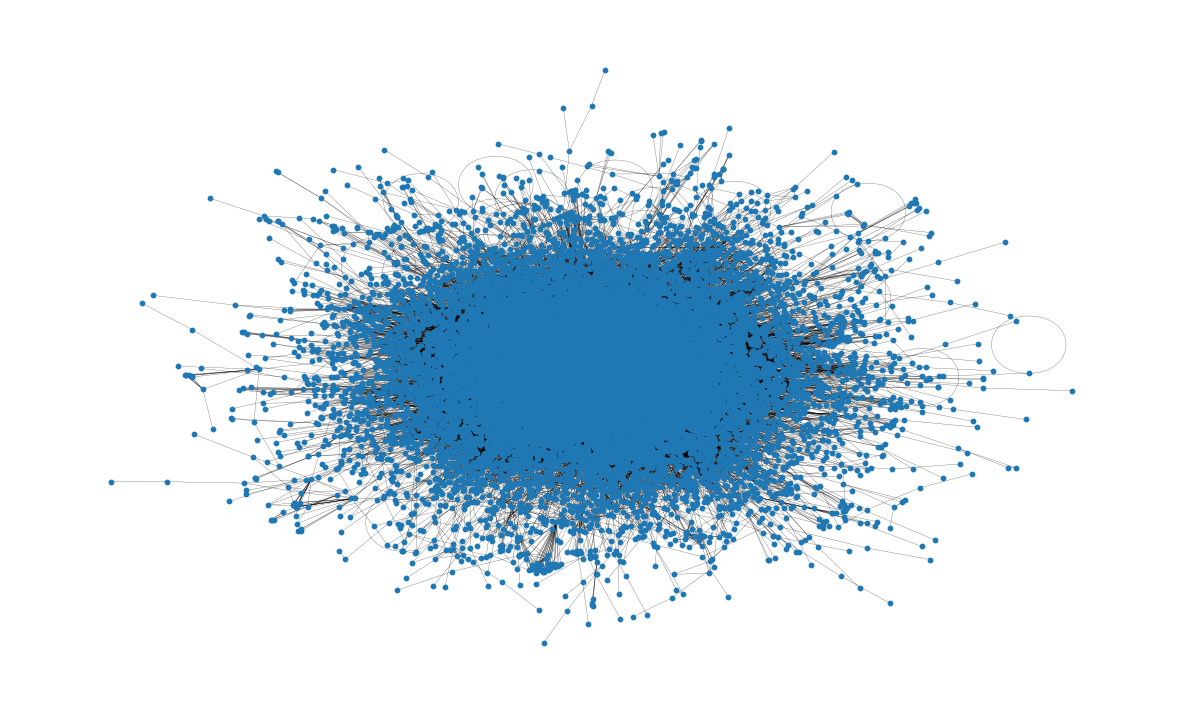

In [ ]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Split dataset

In [ ]:
# Dataset
dataset = FacebookPagePage(root=".")
data = dataset[0]
data.train_mask = range(18000)
data.val_mask = range(18001, 20000)
data.test_mask = range(20001, 22470)

In [ ]:
data

Data(x=[22470, 128], edge_index=[2, 342004], y=[22470], train_mask=[18000], val_mask=[1999], test_mask=[2469])

### Build Adjacency Matrix

In [ ]:
from torch_geometric.utils import to_dense_adj

# Adjacency matrix
adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

# **Accuracy**

Se genera la métrica con la que se evaluarán los ejercicios.

In [ ]:
import torch
torch.manual_seed(0)
from torch.nn import Linear
import torch.nn.functional as F


def accuracy(y_pred, y_true):
    """Calculate accuracy."""
    return torch.sum(y_pred == y_true) / len(y_true)

### Build MLP class

Se genera modelo MLP con train, val y test (también con sus correspondientes máscaras)

In [ ]:
class MLP(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### Build GNN class

Se genera modelo GNN con train, val y test (también con sus correspondientes máscaras)

In [ ]:
class SparseLayer(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.linear = Linear(dim_in, dim_out, bias=False)

    def forward(self, x, adjacency):
        x = self.linear(x)
        x = torch.sparse.mm(adjacency, x)
        return x

In [ ]:
class GNN(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = SparseLayer(dim_in, dim_h)
        self.gnn2 = SparseLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(data.x, adjacency)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            acc = accuracy(out[data.train_mask].argmax(dim=1),
                          data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                                  data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                      f' {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | '
                      f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, adjacency)
        acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
        return acc

### Run models and compare

Se ejecuta el primer par de modelos.

In [ ]:
# MLP
mlp = MLP(dataset.num_features, 16, dataset.num_classes)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

# GCN
gnn = GNN(dataset.num_features, 16, dataset.num_classes)
print(gnn)
gnn.fit(data, epochs=100)
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

MLP(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.466 | Train Acc: 17.61% | Val Loss: 1.47 | Val Acc: 16.61%
Epoch  20 | Train Loss: 0.677 | Train Acc: 73.16% | Val Loss: 0.69 | Val Acc: 71.74%
Epoch  40 | Train Loss: 0.584 | Train Acc: 76.83% | Val Loss: 0.62 | Val Acc: 75.04%
Epoch  60 | Train Loss: 0.556 | Train Acc: 77.97% | Val Loss: 0.61 | Val Acc: 75.39%
Epoch  80 | Train Loss: 0.539 | Train Acc: 78.79% | Val Loss: 0.61 | Val Acc: 75.24%
Epoch 100 | Train Loss: 0.525 | Train Acc: 79.33% | Val Loss: 0.61 | Val Acc: 75.69%

MLP test accuracy: 75.21%

GNN(
  (gnn1): SparseLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): SparseLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 52.936 | Train Acc: 27.18% | Val Loss: 44.15 | Val Acc: 26.11%
Epoch  20 | Train Loss: 4.316 | Train Acc: 80.3

### Split dataset
User a pytorch random split and debug model classes...

In [ ]:
# Example with random_split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

Se observa lo que tiene cada dataset

In [ ]:
train_dataset.dataset.x
test_dataset.dataset.x

tensor([[-0.2626, -0.2765, -0.2624,  ..., -0.2151, -0.3759, -0.2238],
        [-0.2626, -0.2765, -0.2624,  ..., -0.2151, -0.3641, -0.1286],
        [-0.2626, -0.2651, -0.2624,  ..., -0.2151, -0.3759, -0.2238],
        ...,
        [-0.2626, -0.2765, -0.2624,  ..., -0.1804, -0.3721, -0.2226],
        [-0.2626, -0.2765, -0.2624,  ..., -0.2151, -0.3759, -0.2181],
        [-0.2323, -0.2765, -0.2624,  ..., -0.1959, -0.3759, -0.2213]])

Se borran los valores en los data.train,val,test mask para poder ejecutar el programa

### Build MLP class

Debido a que en el código sólo se eliminó la validación al momento de ejecutar el código, sólo se mostrará el train del modelo y finalmente su test.

Adicionalmente se cambia en el ``fit`` dentro del ``out`` en lugar de ser ``data.x`` se pone ``train_dataset.dataset.x`` y en el accuracy ````train_dataset.dataset.y````.

Pasa algo similar en el test pero con su respectiva variable.

Esto ocurre porque no hay "train_mask" y porque los subsets ya generados contienen toda la información necesaria para poder ejecutar el algoritmo.

In [ ]:
class MLP_without_val(torch.nn.Module):
    """Multilayer Perceptron"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.linear1 = Linear(dim_in, dim_h)
        self.linear2 = Linear(dim_h, dim_out)

    def forward(self, x):
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(train_dataset.dataset.x) #Se cambia la salida por el nuevo dataset
            loss = criterion(out, train_dataset.dataset.y) #Se cambia el y por el generado en el sample
            acc = accuracy(out.argmax(dim=1),
                          train_dataset.dataset.y)
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                # val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                # val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                #                   data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% |')
                      # f'  Val Loss: {val_loss:.2f} | '
                      # f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(test_dataset.dataset.x)
        acc = accuracy(out.argmax(dim=1), test_dataset.dataset.y)
        return acc

### Build GNN class

Debido a que en el código sólo se eliminó la validación al momento de ejecutar el código, sólo se mostrará el train del modelo y finalmente su test.

Adicionalmente se cambia en el ``fit`` dentro del ``out`` en lugar de ser ``data.x`` se pone ``train_dataset.dataset.x`` y en el accuracy ````train_dataset.dataset.y````.

Pasa algo similar en el test pero con su respectiva variable.

Esto ocurre porque no hay "train_mask" y porque los subsets ya generados contienen toda la información necesaria para poder ejecutar el algoritmo.

In [ ]:
class GNN_without_val(torch.nn.Module):
    """Vanilla Graph Neural Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gnn1 = SparseLayer(dim_in, dim_h)
        self.gnn2 = SparseLayer(dim_h, dim_out)

    def forward(self, x, adjacency):
        h = self.gnn1(x, adjacency)
        h = torch.relu(h)
        h = self.gnn2(h, adjacency)
        return F.log_softmax(h, dim=1)

    def fit(self, data, epochs):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

        self.train()
        for epoch in range(epochs+1):
            optimizer.zero_grad()
            out = self(train_dataset.dataset.x, adjacency)
            loss = criterion(out, train_dataset.dataset.y)
            acc = accuracy(out.argmax(dim=1),
                          train_dataset.dataset.y)
            loss.backward()
            optimizer.step()

            if(epoch % 20 == 0):
                # val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                # val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                #                   data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% |')
                      # f'  Val Loss: {val_loss:.2f} | '
                      # f'Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(test_dataset.dataset.x, adjacency)
        acc = accuracy(out.argmax(dim=1), test_dataset.dataset.y)
        return acc

### Run and compare models

Se corren los dos modelos generados con anterioridad

In [ ]:
# MLP
mlp = MLP_without_val(dataset.num_features, 16, dataset.num_classes)
print(mlp)
mlp.fit(data, epochs=100)
acc = mlp.test(data)
print(f'\nMLP test accuracy: {acc*100:.2f}%\n')

# GCN
gnn = GNN_without_val(dataset.num_features, 16, dataset.num_classes)
print(gnn)
gnn.fit(data, epochs=100)
acc = gnn.test(data)
print(f'\nGNN test accuracy: {acc*100:.2f}%')

MLP_without_val(
  (linear1): Linear(in_features=128, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4, bias=True)
)
Epoch   0 | Train Loss: 1.387 | Train Acc: 31.90% |
Epoch  20 | Train Loss: 0.652 | Train Acc: 74.05% |
Epoch  40 | Train Loss: 0.578 | Train Acc: 77.07% |
Epoch  60 | Train Loss: 0.553 | Train Acc: 77.88% |
Epoch  80 | Train Loss: 0.539 | Train Acc: 78.44% |
Epoch 100 | Train Loss: 0.528 | Train Acc: 78.97% |

MLP test accuracy: 79.00%

GNN_without_val(
  (gnn1): SparseLayer(
    (linear): Linear(in_features=128, out_features=16, bias=False)
  )
  (gnn2): SparseLayer(
    (linear): Linear(in_features=16, out_features=4, bias=False)
  )
)
Epoch   0 | Train Loss: 46.887 | Train Acc: 33.46% |
Epoch  20 | Train Loss: 4.603 | Train Acc: 80.61% |
Epoch  40 | Train Loss: 1.561 | Train Acc: 83.45% |
Epoch  60 | Train Loss: 0.887 | Train Acc: 83.52% |
Epoch  80 | Train Loss: 0.650 | Train Acc: 84.78% |
Epoch 100 | Train Loss: 0.541 | Train Acc: 85.7

# **Conclusión**

Del ejercicio anterior se pudo concluir que:

- Las GNN en general son mejores que las MLP.
- Separar los dataset con el random_split versus de forma secuencial genera la única diferencia que se tiene en el caso del presente ejercicio es que no se tiene training_mask en la segunda, es por ello que se debe entrenar el "forward" o el "out" con el dataset directo de entrenamiento y de test.
- Los GNN tienen un tiempo considerablemente mayor de entrenamiento que los MLP